In [ ]:
# !wget https://get.station307.com/XBfpC0LRGnv/drivers.csv
# !wget https://get.station307.com/1sMvs6dLFlm/roads_fixed.xml
# !wget https://get.station307.com/iEbAKXXYNi7/orders.csv

Миссия Uklon - дать людям свободу передвижения, непрерывно улучшая сервис заказа автомобиля.
Сотрудничая с автопарками, Uklon заинтересован в максимизации эффективности использования автомобилей и времени, при этом не опуская высокую планку качества обслуживания клиентов (райдеров), с целью наращивания клиентской базы и мотивации повторного использования нашего сервиса как # 1.

Учитывая наличие множества параметров, которые влияют на прибыльность и эффективность, сервис столкнулся с проблемами:  
- **поиск моделей по максимизации доходности;**  
- **поиск оптимальной модели прогноза доходности на предстоящий период.**  

В то же время, для обеспечения высокого качества обслуживания, перед компанией стоит задача удержания (недопущение увольнения) лучших водителей (драйверов).  
G(V, E) - граф, V - вершины(перекрестки), E - дороги  
N - вершина  
L - список соседей  
TN - соседняя вершина  
SCH - расписание движения по сегменту  
SL - ограничение по скорости на сегмент  
Автопарк представлен множеством автомобилей D с закрепленными за ними водителями. Каждому водителю di необходимо поставить в соответствие рейтинг ri на основании отзывов пассажиров.

Каждый из водителей имеет право на два выходных дня в неделю, один из которых является обязательным.

orders: точка начала, точка конца, время начала, время конца, айди водителя, оценка, стоимость

Вознаграждение водителей определяется как доля (процент) от выполненного заказа с учетом затрат на энергоноситель. Предполагается, что все водители используют один и тот же энергоноситель с единой ценой с одинаковым потреблением (расходом). 

**Прибыль автопарка формируется как остаток от стоимости поездки минус стоимость энергоносителя и вознаграждение водителя.**   

С целью удержания (недопущение увольнения) лучших водителей, компания приняла решение разработать подход или модель, / ий помог (а) бы помочь водителям с лучшим рейтингом зарабатывать больше.
В качестве дополнительного бонуса для водителей, руководство позволяет парковать машины на ночь как можно ближе к месту жительства водителя. И, как следствие, необходимо решение, позволяющее наилучшим водителям брать первого пассажира и высаживать последнего можно ближе к своему дому. 

Информация о координатах проживания водителей представлена в файле drivers.csv, где driverID - идентификатор драйвера, lat - широта, lon - долгота.
критерии:

асимптотика 100  
учет скоростных ограничений 50  
учет расписания 50  
справедливая метрика оценки качества работы водителей: 50  
учет бонусной ночной парковки: 30  
можно прогнозировать доход драйвера на завтра: 75  
можно предсказать, когда лучше взять выходной: 50  
получает наибольшую прибыль: 100  
MVP + кросс-валидация: 100  
Побеждает та команда, которая набрала больше всего баллов из расчета на каждого участника команды, то есть общее количество баллов по задачу делится на количество членов команды и этот показатель учитывается при определении победителя.

Если команды получают одинаковую оценку задачу, то побеждает та, которая показала лучший результат по выполнению требований с самыми высокими оценками в баллах.

5000 водителей, 1 000 000 поездок

In [301]:
import datetime
import ipywidgets
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import shap
import sys

from numpy.linalg import LinAlgError
from scipy.optimize import basinhopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose


from tqdm import tqdm

In [2]:
import xml.etree.ElementTree as ET

tree = ET.parse('roads_fixed.xml')
root = tree.getroot()

In [3]:
root[0][0][0].attrib

{'Lat': '49.79958', 'Long': '22.95301'}

In [4]:
drivers = pd.read_csv("drivers.csv")
drivers

,driverID,lat,lon
0,1692141,49.85359,23.99071
1,3241470,49.84419,24.09416
2,3118778,49.78185,24.05799
3,3837509,49.84421,24.00969
4,3857976,49.83918,24.02938
...,...,...,...
4906,1545035,49.84160,24.02685
4907,2557930,49.78677,24.01646
4908,2096815,49.83922,23.97052
4909,1461819,49.84165,24.09822


In [339]:
orders = pd.read_csv("orders.csv")
orders

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN
...,...,...,...,...,...,...,...,...,...
935304,3086077,8/12/2020 10:37,49.81990,23.96511,56.93698,8/12/2020 9:36,49.83745,24.03000,5.0
935305,1928136,9/29/2020 20:52,49.92522,23.56896,56.04312,9/29/2020 19:57,49.83398,23.98803,5.0
935306,1783393,9/10/2020 13:45,49.92522,23.56896,57.11902,9/10/2020 13:05,49.81372,23.96011,5.0
935307,2410045,9/8/2020 19:40,49.83920,24.03001,61.20409,9/8/2020 17:37,49.81141,24.08028,5.0


In [6]:
xs = []
ys = []

for v in root.findall('N'):
    xs.append(float(v.get('Lat')))
    ys.append(float(v.get('Long')))

city = pd.DataFrame.from_dict({
    "lat": xs,
    "lon":ys
})
city

,lat,lon
0,49.79960,22.95196
1,49.79958,22.95301
2,49.79967,22.95369
3,49.79961,22.95467
4,49.79953,22.95519
...,...,...
76079,50.13156,25.24307
76080,50.13161,25.24362
76081,50.13150,25.24418
76082,50.13057,25.24557


In [9]:
pd.to_datetime(orders.loc[0, "pickupTime"])

Timestamp('2020-10-06 20:54:00')

In [10]:
orders.loc[0, "pickupTime"]

'10/6/2020 20:54'

In [319]:
# pickup = pd.to_datetime(orders["pickupTime"])
# pickup

In [320]:
# dropoff = pd.to_datetime(orders["dropoffTime"])
# dropoff

In [338]:
orders = pd.read_csv("time_orders.csv", index_col=0)
orders

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating,pickup,dropoff
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0,2020-10-06 20:54:00,2020-10-06 21:34:00
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN,2020-10-06 22:22:00,2020-10-06 22:41:00
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0,2020-10-07 10:14:00,2020-10-07 10:25:00
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN,2020-10-07 13:35:00,2020-10-07 13:42:00
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN,2020-10-07 14:49:00,2020-10-07 15:29:00
...,...,...,...,...,...,...,...,...,...,...,...
935304,3086077,8/12/2020 10:37,49.81990,23.96511,56.93698,8/12/2020 9:36,49.83745,24.03000,5.0,2020-08-12 09:36:00,2020-08-12 10:37:00
935305,1928136,9/29/2020 20:52,49.92522,23.56896,56.04312,9/29/2020 19:57,49.83398,23.98803,5.0,2020-09-29 19:57:00,2020-09-29 20:52:00
935306,1783393,9/10/2020 13:45,49.92522,23.56896,57.11902,9/10/2020 13:05,49.81372,23.96011,5.0,2020-09-10 13:05:00,2020-09-10 13:45:00
935307,2410045,9/8/2020 19:40,49.83920,24.03001,61.20409,9/8/2020 17:37,49.81141,24.08028,5.0,2020-09-08 17:37:00,2020-09-08 19:40:00


In [343]:
orders["pickup"] = pickup
orders["dropoff"] = dropoff
orders["week_day"] = orders["pickup"].dt.day_name()
orders

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating,pickup,dropoff,date,week_day
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0,2020-10-06 20:54:00,2020-10-06 21:34:00,2020-10-06,Tuesday
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN,2020-10-06 22:22:00,2020-10-06 22:41:00,2020-10-06,Tuesday
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0,2020-10-07 10:14:00,2020-10-07 10:25:00,2020-10-07,Wednesday
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN,2020-10-07 13:35:00,2020-10-07 13:42:00,2020-10-07,Wednesday
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN,2020-10-07 14:49:00,2020-10-07 15:29:00,2020-10-07,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
935304,3086077,8/12/2020 10:37,49.81990,23.96511,56.93698,8/12/2020 9:36,49.83745,24.03000,5.0,2020-08-12 09:36:00,2020-08-12 10:37:00,2020-08-12,Wednesday
935305,1928136,9/29/2020 20:52,49.92522,23.56896,56.04312,9/29/2020 19:57,49.83398,23.98803,5.0,2020-09-29 19:57:00,2020-09-29 20:52:00,2020-09-29,Tuesday
935306,1783393,9/10/2020 13:45,49.92522,23.56896,57.11902,9/10/2020 13:05,49.81372,23.96011,5.0,2020-09-10 13:05:00,2020-09-10 13:45:00,2020-09-10,Thursday
935307,2410045,9/8/2020 19:40,49.83920,24.03001,61.20409,9/8/2020 17:37,49.81141,24.08028,5.0,2020-09-08 17:37:00,2020-09-08 19:40:00,2020-09-08,Tuesday


In [345]:
orders = orders[orders["fare"] < 500]

In [346]:
orders["date"] = orders["pickup"].dt.date
gr = orders[["fare", "date"]].groupby("date").agg("sum")
gr["fare"]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date
2020-05-08    25343.10022
2020-05-09    25309.42158
2020-05-10    23816.69033
2020-05-11    25870.60567
2020-05-12    27361.20631
                 ...     
2020-11-04    50601.28650
2020-11-05    55571.48356
2020-11-06    69241.84058
2020-11-07    65122.54455
2020-11-08    59878.32321
Name: fare, Length: 185, dtype: float64

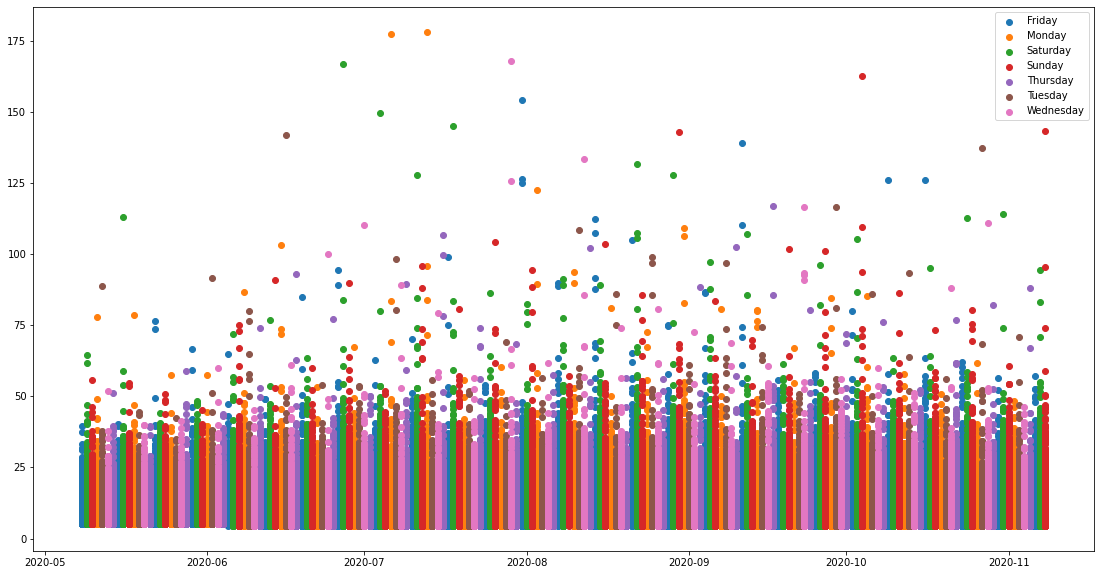

In [347]:
def draw_fare():  
    fig = plt.figure(figsize=(19, 10))
    ax = plt.axes()
    
    gr = orders[["date", "fare", "week_day"]].groupby("week_day") 

    for name, g in gr:
        ax.scatter(g["date"], g["fare"], label=name)
    ax.legend()

    plt.show()
    
draw_fare()

In [358]:
a = pd.DataFrame(columns=["fare", "week_day"])
a["week_day"] = pd.to_datetime(pd.DataFrame(gr.index)["date"]).dt.day_name()
a["fare"] = gr["fare"].values
a["pickup"] = gr.index
a["pickup"] = pd.to_datetime(a["pickup"])
a

,fare,week_day,pickup
0,25343.10022,Friday,2020-05-08
1,25309.42158,Saturday,2020-05-09
2,23816.69033,Sunday,2020-05-10
3,25870.60567,Monday,2020-05-11
4,27361.20631,Tuesday,2020-05-12
...,...,...,...
180,50601.28650,Wednesday,2020-11-04
181,55571.48356,Thursday,2020-11-05
182,69241.84058,Friday,2020-11-06
183,65122.54455,Saturday,2020-11-07


In [392]:
week = datetime.timedelta(days=7)

b = a.\
    rolling(window=week, on="pickup").\
    mean()
b["week_day"] = a["week_day"]
b

,fare,pickup,week_day
0,25343.100220,2020-05-08,Friday
1,25326.260900,2020-05-09,Saturday
2,24823.070710,2020-05-10,Sunday
3,25084.954450,2020-05-11,Monday
4,25540.204822,2020-05-12,Tuesday
...,...,...,...
180,60365.250253,2020-11-04,Wednesday
181,60060.890191,2020-11-05,Thursday
182,60204.829861,2020-11-06,Friday
183,58938.018899,2020-11-07,Saturday


In [398]:
c = b.copy()
c["fare"] = difference(c["fare"], 1)
c = c.\
    rolling(window=week, on="pickup").\
    mean()
c["week_day"] = a["week_day"]
c

,fare,pickup,week_day
0,25343.100220,2020-05-08,Friday
1,12654.710790,2020-05-09,Saturday
2,7938.896777,2020-05-10,Sunday
3,6467.651418,2020-05-11,Monday
4,5472.241262,2020-05-12,Tuesday
...,...,...,...
180,-708.165873,2020-11-04,Wednesday
181,-304.360061,2020-11-05,Thursday
182,143.939670,2020-11-06,Friday
183,-1266.810963,2020-11-07,Saturday


In [386]:
def difference(dataset, interval=1):
    diff = list(dataset[0:interval])
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


def inverse_difference(last_ob, value):
    return value + last_ob

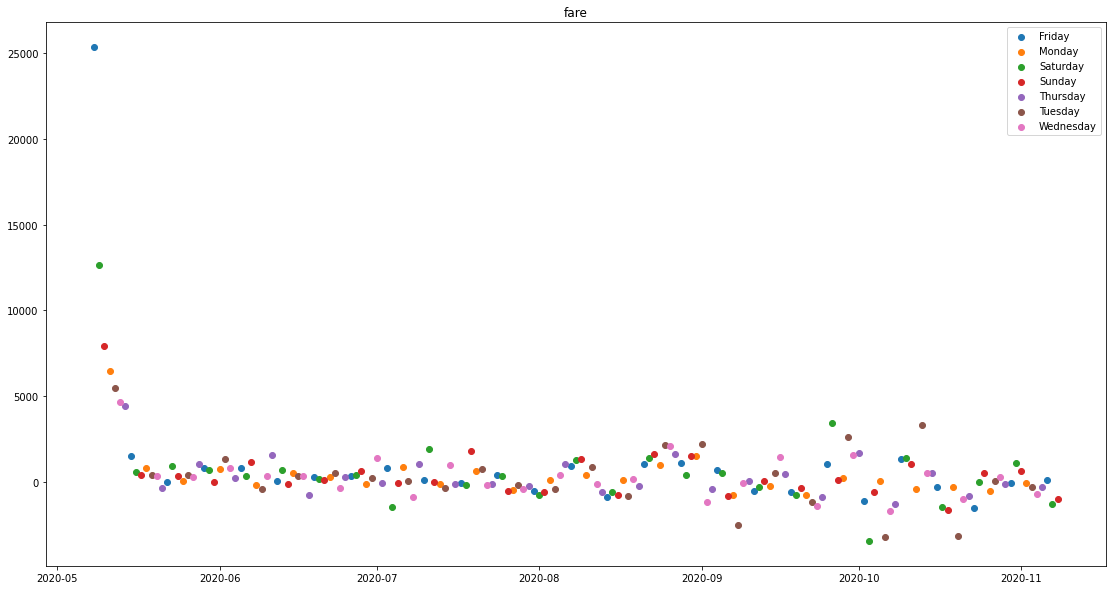

In [399]:
def draw_weeks(data, feature):  
    fig = plt.figure(figsize=(19, 10))
    ax = plt.axes()

    gr_by_week = data.groupby('week_day')

    for name, group in gr_by_week:
        ax.scatter(group['pickup'], group[feature], label=name)
    ax.set_title(feature)
    ax.legend()

    plt.show()
    
draw_weeks(c, "fare")

In [95]:
week = datetime.timedelta(days=7)

b = orders[["fare", "pickup"]].sort_values(['pickup']).\
    rolling(window=week, on="pickup").\
    mean()
b

,fare,pickup
433723,11.156810,2020-05-08 00:01:00
192580,9.608205,2020-05-08 00:02:00
833975,9.190713,2020-05-08 00:03:00
928015,9.844297,2020-05-08 00:04:00
206799,11.164978,2020-05-08 00:04:00
...,...,...
875052,10.178113,2020-11-08 23:58:00
851920,10.178084,2020-11-08 23:58:00
321374,10.178063,2020-11-08 23:58:00
569922,10.178074,2020-11-08 23:58:00


In [260]:
import os
import tqdm
import torch

from sklearn.metrics.pairwise import haversine_distances
from math import radians

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [239]:
orders

,lat,lon,pickup
0,49.79960,22.95196,0
1,49.79958,22.95301,0
2,49.79967,22.95369,0
3,49.79961,22.95467,0
4,49.79953,22.95519,0
...,...,...,...
76079,50.13156,25.24307,0
76080,50.13161,25.24362,0
76081,50.13150,25.24418,0
76082,50.13057,25.24557,0


In [273]:
torch.cuda.empty_cache()

In [274]:
rad = 3
earth_const = 6371000 / 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ver_orders3 = []

city_rows = torch.deg2rad(torch.from_numpy(city[["lat", "lon"]].to_numpy()).to(device))
order_rows = torch.deg2rad(torch.from_numpy(orders[["pickup_lat", "pickup_lon"]].to_numpy()).to(device))

In [288]:
for x in tqdm.notebook.tqdm(city_rows):
    
    vertex_orders = 0
    for y in order_rows:
        if 2 * torch.arcsin(torch.sqrt(torch.sin((x[0] - y[0]) / 2) ** 2 + 
                                       torch.cos(x[0]) * torch.cos(y[0]) * 
                                        (torch.sin((x[1] - y[1]) / 2)) ** 2)) * earth_const <= rad:
            vertex_orders += 1
    
    ver_orders3.append(vertex_orders)
    break

ver_orders3

KeyboardInterrupt: 

In [268]:
a = radiantorch.from_numpy(orders[["pickup_lat", "pickup_lon"]].to_numpy())[0].to(device)


tensor([49.7066, 23.9152], device='cuda:0', dtype=torch.float64)

In [ ]:
city["pickup3"] = ver_orders3
city

In [199]:
city.to_csv("./city")

In [135]:
city.groupby("pickup2").agg("count")

,lat,lon,pickup
pickup2,,,
0,64010,64010,64010
1,4722,4722,4722
2,1940,1940,1940
3,1152,1152,1152
4,744,744,744
...,...,...,...
418,1,1,1
506,1,1,1
609,1,1,1


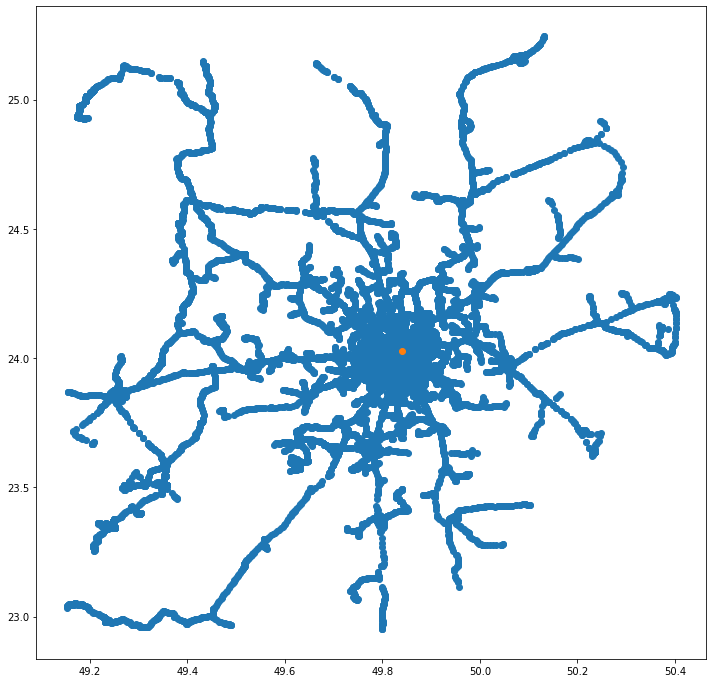

In [139]:
def draw_map():  
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes()

    ax.scatter(xs, ys)
    
#     ccc = city[(city["pickup2"] > 0) & (city["pickup2"] < 10)]
#     img = ax.scatter(ccc["lat"], ccc["lon"], c=ccc["pickup2"], alpha=0.3, cmap='viridis')
    ccc = city[city["pickup2"] > 680]
    ax.scatter(ccc["lat"], ccc["lon"])
#     fig.colorbar(img, ax=ax)

    plt.show()
    
draw_map()

In [140]:
orders

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating,pickup,dropoff,week_day,date
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0,2020-10-06 20:54:00,2020-10-06 21:34:00,Tuesday,2020-10-06
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN,2020-10-06 22:22:00,2020-10-06 22:41:00,Tuesday,2020-10-06
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0,2020-10-07 10:14:00,2020-10-07 10:25:00,Wednesday,2020-10-07
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN,2020-10-07 13:35:00,2020-10-07 13:42:00,Wednesday,2020-10-07
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN,2020-10-07 14:49:00,2020-10-07 15:29:00,Wednesday,2020-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
935304,3086077,8/12/2020 10:37,49.81990,23.96511,56.93698,8/12/2020 9:36,49.83745,24.03000,5.0,2020-08-12 09:36:00,2020-08-12 10:37:00,Wednesday,2020-08-12
935305,1928136,9/29/2020 20:52,49.92522,23.56896,56.04312,9/29/2020 19:57,49.83398,23.98803,5.0,2020-09-29 19:57:00,2020-09-29 20:52:00,Tuesday,2020-09-29
935306,1783393,9/10/2020 13:45,49.92522,23.56896,57.11902,9/10/2020 13:05,49.81372,23.96011,5.0,2020-09-10 13:05:00,2020-09-10 13:45:00,Thursday,2020-09-10
935307,2410045,9/8/2020 19:40,49.83920,24.03001,61.20409,9/8/2020 17:37,49.81141,24.08028,5.0,2020-09-08 17:37:00,2020-09-08 19:40:00,Tuesday,2020-09-08


In [294]:
driv_gr = orders[["driverID", "week_day", "fare"]].groupby(["driverID", "week_day"]).agg("count")
driv_gr

fare
driverID week_day      
59551    Friday       4
         Saturday     5
         Sunday       1
         Thursday     4
         Tuesday      1
...                 ...
4011348  Friday       6
         Saturday     1
4011445  Friday       4
         Saturday     8
         Sunday       7

[27680 rows x 1 columns]

In [177]:
driv_gr.loc[driv_gr.index[0]]

fare    4
Name: (59551, Friday), dtype: int64

In [296]:
week_days = ["Monday", 
             "Tuesday", 
             "Wednesday",
             "Thursday",
             "Friday",
             "Saturday",
             "Sunday"]

drivers_features = pd.DataFrame(columns=week_days, index=np.unique(drivers["driverID"]))

for index in tqdm.notebook.tqdm(driv_gr.index):
    drivers_features.loc[index[0], index[1]] = driv_gr.loc[index, "fare"]

drivers_features

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
59551,NaN,1,1,4,4,5,1
62539,16,33,36,29,29,30,17
86969,10,6,5,3,7,1,10
206868,NaN,NaN,NaN,1,NaN,3,3
211940,7,15,16,21,16,6,7
...,...,...,...,...,...,...,...
4008019,NaN,NaN,NaN,NaN,2,3,NaN
4008461,NaN,NaN,NaN,5,11,8,3
4010073,NaN,NaN,NaN,NaN,2,NaN,NaN
4011348,NaN,NaN,NaN,NaN,6,1,NaN


In [297]:
drivers_features = drivers_features.fillna(0)

In [298]:
drivers_features = pd.read_csv("drivers_features.csv", index_col=0)
drivers_features["trips"] = drivers_features.sum(axis=1)
drivers_features

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,trips,defect
59551,0.000000,0.062500,0.062500,0.250000,0.250000,0.312500,0.062500,17.000000,0.000000
62539,0.084211,0.173684,0.189474,0.152632,0.152632,0.157895,0.089474,191.031250,0.031250
86969,0.238095,0.142857,0.119048,0.071429,0.166667,0.023810,0.238095,43.000000,0.000000
206868,0.000000,0.000000,0.000000,0.142857,0.000000,0.428571,0.428571,8.000000,0.000000
211940,0.079545,0.170455,0.181818,0.238636,0.181818,0.068182,0.079545,89.052632,0.052632
...,...,...,...,...,...,...,...,...,...
4008019,0.000000,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,6.000000,0.000000
4008461,0.000000,0.000000,0.000000,0.185185,0.407407,0.296296,0.111111,28.000000,0.000000
4010073,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000
4011348,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.000000,8.000000,0.000000


In [219]:
for wd in week_days:
    drivers_features[wd] = drivers_features[wd] / drivers_features["trips"]
drivers_features

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,trips
59551,0.000000,0.062500,0.062500,0.250000,0.250000,0.312500,0.062500,16
62539,0.084211,0.173684,0.189474,0.152632,0.152632,0.157895,0.089474,190
86969,0.238095,0.142857,0.119048,0.071429,0.166667,0.023810,0.238095,42
206868,0.000000,0.000000,0.000000,0.142857,0.000000,0.428571,0.428571,7
211940,0.079545,0.170455,0.181818,0.238636,0.181818,0.068182,0.079545,88
...,...,...,...,...,...,...,...,...
4008019,0.000000,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,5
4008461,0.000000,0.000000,0.000000,0.185185,0.407407,0.296296,0.111111,27
4010073,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2
4011348,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.000000,7


In [299]:
marks = orders[["driverID", "rideRating"]].groupby("driverID").agg("count")
bad_marks = orders[["driverID", "rideRating"]].\
                loc[orders["rideRating"] < 5].\
                groupby("driverID").agg("count")

marks["bad"] = bad_marks["rideRating"]
marks["defect"] = (marks["bad"] / marks["rideRating"]).fillna(0)
marks

,rideRating,bad,defect
driverID,,,
59551,3,NaN,0.000000
62539,32,1.0,0.031250
86969,12,NaN,0.000000
206868,0,NaN,0.000000
211940,19,1.0,0.052632
...,...,...,...
4008019,2,NaN,0.000000
4008461,3,NaN,0.000000
4010073,0,NaN,0.000000


In [300]:
drivers_features["defect"] = marks["defect"]
drivers_features

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,trips,defect
59551,0.000000,0.062500,0.062500,0.250000,0.250000,0.312500,0.062500,17.000000,0.000000
62539,0.084211,0.173684,0.189474,0.152632,0.152632,0.157895,0.089474,191.031250,0.031250
86969,0.238095,0.142857,0.119048,0.071429,0.166667,0.023810,0.238095,43.000000,0.000000
206868,0.000000,0.000000,0.000000,0.142857,0.000000,0.428571,0.428571,8.000000,0.000000
211940,0.079545,0.170455,0.181818,0.238636,0.181818,0.068182,0.079545,89.052632,0.052632
...,...,...,...,...,...,...,...,...,...
4008019,0.000000,0.000000,0.000000,0.000000,0.400000,0.600000,0.000000,6.000000,0.000000
4008461,0.000000,0.000000,0.000000,0.185185,0.407407,0.296296,0.111111,28.000000,0.000000
4010073,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000
4011348,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.000000,8.000000,0.000000


In [292]:
drivers_features.to_csv("./drivers_features.csv")

In [306]:
orders.groupby("driverID").head(50)

,driverID,dropoffTime,dropoff_lat,dropoff_lon,fare,pickupTime,pickup_lat,pickup_lon,rideRating,pickup,dropoff,week_day,date
0,1152571,10/6/2020 21:34,49.83972,23.99442,26.63804,10/6/2020 20:54,49.70660,23.91523,5.0,2020-10-06 20:54:00,2020-10-06 21:34:00,Tuesday,2020-10-06
1,3294889,10/6/2020 22:41,49.83972,23.99442,9.09288,10/6/2020 22:22,49.86757,24.04048,NaN,2020-10-06 22:22:00,2020-10-06 22:41:00,Tuesday,2020-10-06
2,1695164,10/7/2020 10:25,49.83972,23.99442,6.84914,10/7/2020 10:14,49.83738,24.02959,5.0,2020-10-07 10:14:00,2020-10-07 10:25:00,Wednesday,2020-10-07
3,2290241,10/7/2020 13:42,49.83972,23.99442,7.03987,10/7/2020 13:35,49.84659,24.03938,NaN,2020-10-07 13:35:00,2020-10-07 13:42:00,Wednesday,2020-10-07
4,3442427,10/7/2020 15:29,49.83972,23.99442,12.55249,10/7/2020 14:49,49.81935,24.01403,NaN,2020-10-07 14:49:00,2020-10-07 15:29:00,Wednesday,2020-10-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
935142,1112957,9/28/2020 10:28,49.82114,24.06029,26.91915,9/28/2020 9:47,49.77698,23.97653,5.0,2020-09-28 09:47:00,2020-09-28 10:28:00,Monday,2020-09-28
935189,1158914,6/28/2020 21:22,49.81443,24.01444,28.51957,6/28/2020 20:48,49.84136,23.89662,5.0,2020-06-28 20:48:00,2020-06-28 21:22:00,Sunday,2020-06-28
935229,641508,6/13/2020 16:38,49.86586,23.96389,32.39091,6/13/2020 16:01,49.75232,24.00714,5.0,2020-06-13 16:01:00,2020-06-13 16:38:00,Saturday,2020-06-13
935258,2239024,6/28/2020 10:37,49.85570,24.02601,37.06590,6/28/2020 10:06,49.83236,24.12279,5.0,2020-06-28 10:06:00,2020-06-28 10:37:00,Sunday,2020-06-28


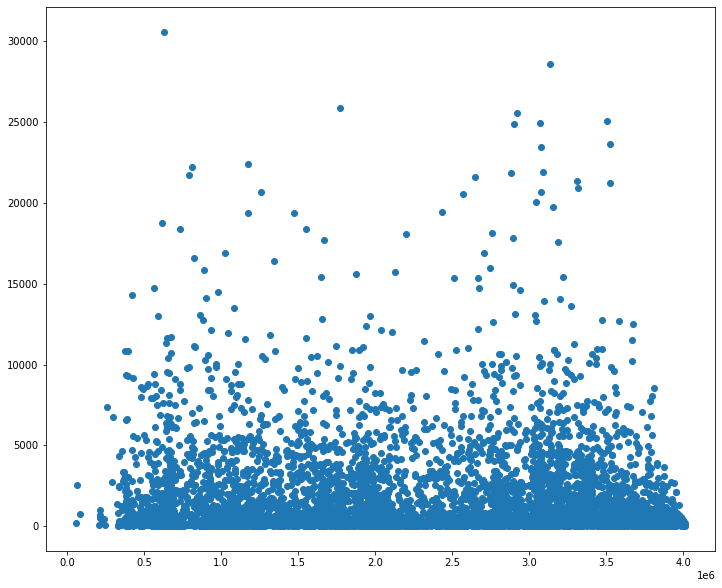

In [409]:
d_gr = orders[["driverID", "fare"]].groupby("driverID").agg("sum")
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
ax.scatter(d_gr.index, d_gr["fare"])
plt.show()

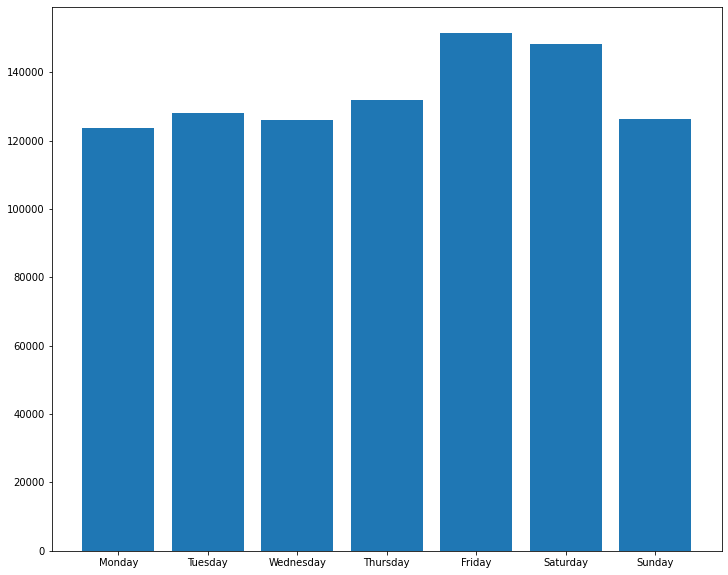

In [421]:
ggg = orders[["driverID", "week_day"]].groupby("week_day").agg("count")
ggg = ggg.sort_index()

gggg = []
for wd in week_days:
    gggg.append(ggg.loc[wd]["driverID"])

fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
ax.bar(week_days, gggg)
plt.show()

In [423]:
def rider_class(rider, orders, thr1=0.28, thr2=0.17, thr3=0.23):
    grades = orders[orders['driverID'] == rider]['rideRating'].to_numpy()
    nrides = grades.shape[0]
    grades = [(grades == i).mean() for i in [-1, 1, 2, 3, 4, 5]]
    positive = grades[-1]
    # negative = sum(grades[1:-1])
    if nrides < 30:
        if positive > thr3:
            return [1, positive]
        return [2, positive]
    if positive > thr1:
        return [1, positive]
    if positive > thr2:
        return [2, positive]
    return [3, positive]

In [425]:
riders = np.unique(orders["driverID"])
classes = []

for rider in riders:
    classes.append(rider_class(rider, orders))

classes

[[2, 0.1875],
 [3, 0.1631578947368421],
 [1, 0.2857142857142857],
 [2, 0.0],
 [2, 0.20454545454545456],
 [2, 0.20270270270270271],
 [2, 0.21739130434782608],
 [2, 0.18518518518518517],
 [1, 0.29545454545454547],
 [2, 0.125],
 [2, 0.19410977242302543],
 [2, 0.17110266159695817],
 [1, 0.37553956834532376],
 [2, 0.2748091603053435],
 [1, 0.28378378378378377],
 [2, 0.0],
 [2, 0.0],
 [2, 0.2],
 [3, 0.10852713178294573],
 [2, 0.1111111111111111],
 [1, 0.28484848484848485],
 [2, 0.0],
 [1, 0.4],
 [1, 0.8],
 [1, 0.46875],
 [2, 0.17857142857142858],
 [2, 0.19658119658119658],
 [3, 0.16666666666666666],
 [1, 0.2929061784897025],
 [2, 0.20353982300884957],
 [2, 0.08333333333333333],
 [2, 0.1901639344262295],
 [2, 0.21518987341772153],
 [2, 0.19784172661870503],
 [2, 0.10526315789473684],
 [2, 0.21476510067114093],
 [1, 0.4],
 [2, 0.21005917159763313],
 [2, 0.23107569721115537],
 [2, 0.2543352601156069],
 [2, 0.2],
 [2, 0.22010869565217392],
 [2, 0.18888888888888888],
 [2, 0.0],
 [2, 0.20895522388

In [432]:
classes = np.array(classes)
classes[:, 0]

array([2., 3., 1., ..., 2., 2., 2.])

In [437]:
def color_from_class(c):
    if c == 1:
        return (1, 0, 0)
    elif c == 2:
        return (0, 1, 0)
    else:
        return (0, 0, 1)

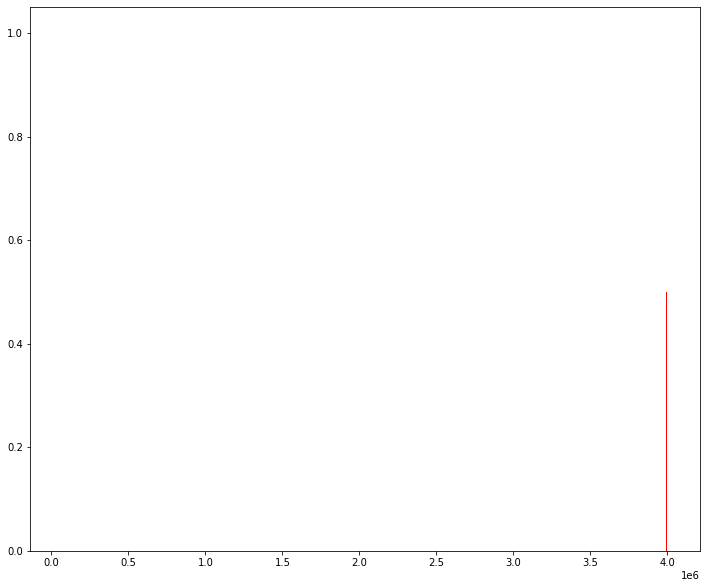

In [438]:
c = [color_from_class(c) for c in classes[:, 0]]
rates = classes[:, 1]

fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
ax.bar(riders, rates, color=c)
plt.show()

In [445]:
(rates > 0.3).sum()

537

In [441]:
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
ax.bar(riders, rates, color=c)
plt.show()

array([0.1875    , 0.16315789, 0.28571429, ..., 0.        , 0.14285714,
       0.15789474])